In [1]:
pip install pandas scikit-learn matplotlib seaborn nltk


Note: you may need to restart the kernel to use updated packages.



--- Classification Report ---
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4311
           1       0.99      0.98      0.98      4669

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980


Accuracy: 0.9829


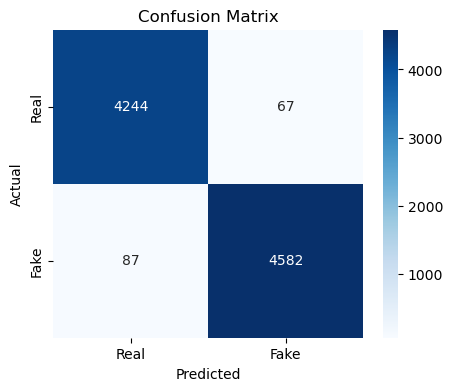


Prediction: REAL
Bayesian Explanation (Posterior Probabilities):
P(Real | Article) = 0.9357
P(Fake | Article) = 0.0643


In [6]:
# --- 1. Import Required Libraries ---
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.calibration import CalibratedClassifierCV

# --- 2. Load and Label Data ---
true_df = pd.read_csv('true.csv')
fake_df = pd.read_csv('fake.csv')

true_df['label'] = 0  # Real
fake_df['label'] = 1  # Fake

df = pd.concat([true_df, fake_df], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# --- 3. Text Cleaning Function ---
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['text'] = df['text'].apply(clean_text)

# --- 4. Feature Extraction (TF-IDF) ---
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X = vectorizer.fit_transform(df['text'])
y = df['label']

# --- 5. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 6. Train Logistic Regression with Probability Calibration ---
lr_model = LogisticRegression(max_iter=1000)
calibrated_model = CalibratedClassifierCV(lr_model, cv=5)
calibrated_model.fit(X_train, y_train)

# --- 7. Evaluation ---
y_pred = calibrated_model.predict(X_test)
y_proba = calibrated_model.predict_proba(X_test)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))
print("\nAccuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# --- 8. Predict and Explain with Bayes Theorem ---
def explain_with_bayes(text):
    cleaned = clean_text(text)
    vec = vectorizer.transform([cleaned])
    pred = calibrated_model.predict(vec)[0]
    proba = calibrated_model.predict_proba(vec)[0]

    label = "FAKE" if pred == 1 else "REAL"
    print(f"\nPrediction: {label}")
    print("Bayesian Explanation (Posterior Probabilities):")
    print(f"P(Real | Article) = {proba[0]:.4f}")
    print(f"P(Fake | Article) = {proba[1]:.4f}")

# --- 9. Example ---
sample_news = "The government has announced new healthcare policies starting next year."
explain_with_bayes(sample_news)


In [8]:
import joblib

# Save the TF-IDF vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')


# Save the trained calibrated logistic regression model
joblib.dump(calibrated_model, 'calibrated_lr_model.joblib')


['calibrated_lr_model.joblib']

In [10]:
import os
print(os.getcwd())


C:\Users\NAC


In [10]:
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')


['tfidf_vectorizer.joblib']

Duplicate texts: 6252
Best parameters: {'C': 10}
Best cross-validation score: 0.9883388796428539

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4239
           1       0.99      0.98      0.99      3479

    accuracy                           0.99      7718
   macro avg       0.99      0.99      0.99      7718
weighted avg       0.99      0.99      0.99      7718


Accuracy: 0.9883


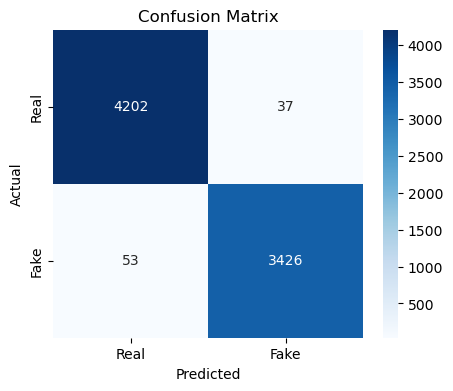

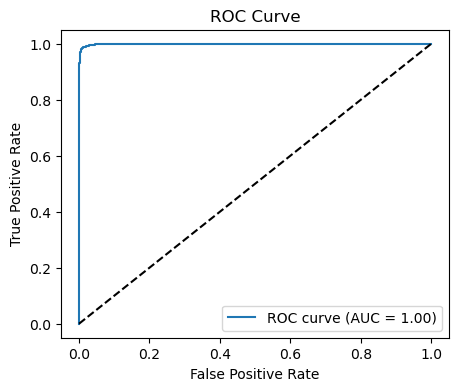


Top words for Fake News:
america: 7.4215
like: 7.4628
rep: 7.5632
sen: 7.7923
mr: 7.9962
read: 8.0297
hillary: 8.7481
wire: 8.7653
gop: 12.3865
image: 22.7569

Top words for Real News:
reuters: -60.7855
don: -13.6867
washington: -12.6215
wednesday: -11.9203
tuesday: -11.5165
thursday: -11.2684
ve: -10.8633
monday: -9.9331
friday: -9.6353
nov: -9.4971
Prediction: REAL
Bayesian Explanation:
P(Real | Article) = 0.6333
P(Fake | Article) = 0.3667
Prior P(Real) = 0.5491
Prior P(Fake) = 0.4509
Note: Likelihoods are approximated by the model based on TF-IDF features.


In [3]:
# Fake News Detector
# Combines NLP, Logistic Regression, and Bayesian Inference to classify news articles as real or fake.

import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import os
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)

# Text Cleaning Function
def clean_text(text):
    """Clean and preprocess text data."""
    if not isinstance(text, str):
        return ''
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize spaces
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Load and Label Data
def load_data(true_path='true.csv', fake_path='fake.csv'):
    """Load and concatenate true and fake news datasets."""
    try:
        if not os.path.exists(true_path) or not os.path.exists(fake_path):
            raise FileNotFoundError("Dataset files not found.")
        true_df = pd.read_csv(true_path)
        fake_df = pd.read_csv(fake_path)
        if 'text' not in true_df.columns or 'text' not in fake_df.columns:
            raise ValueError("Datasets must contain a 'text' column.")
        true_df['label'] = 0  # Real
        fake_df['label'] = 1  # Fake
        df = pd.concat([true_df, fake_df], ignore_index=True)
        return df.sample(frac=1, random_state=42).reset_index(drop=True)
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Main processing
df = load_data()
if df is None:
    raise SystemExit("Exiting due to data loading error.")

# Check for duplicates
print("Duplicate texts:", df['text'].duplicated().sum())
df = df.drop_duplicates(subset='text', keep='first')

df['text'] = df['text'].apply(clean_text)
df = df[df['text'].str.strip() != '']  # Remove empty texts

# Feature Extraction (TF-IDF)
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X = vectorizer.fit_transform(df['text'])
y = df['label']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression with Hyperparameter Tuning
param_grid = {'C': [0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

lr_model = grid_search.best_estimator_  # Use best estimator directly
calibrated_model = CalibratedClassifierCV(lr_model, cv=5)
calibrated_model.fit(X_train, y_train)

# Save model and vectorizer
joblib.dump(calibrated_model, 'fake_news_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

# Evaluation
y_pred = calibrated_model.predict(X_test)
y_proba = calibrated_model.predict_proba(X_test)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))
print("\nAccuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Feature Importance
feature_names = vectorizer.get_feature_names_out()
coefficients = lr_model.coef_[0]  # Use best_estimator_'s coef_
top_indices = np.argsort(coefficients)[-10:]
bottom_indices = np.argsort(coefficients)[:10]
print("\nTop words for Fake News:")
for i in top_indices:
    print(f"{feature_names[i]}: {coefficients[i]:.4f}")
print("\nTop words for Real News:")
for i in bottom_indices:
    print(f"{feature_names[i]}: {coefficients[i]:.4f}")

# Predict and Explain with Bayes Theorem
def explain_with_bayes(text):
    """Predict and explain news article classification using Bayes' theorem."""
    if not isinstance(text, str) or not text.strip():
        return "Error: Input must be a non-empty string."
    cleaned = clean_text(text)
    vec = vectorizer.transform([cleaned])
    pred = calibrated_model.predict(vec)[0]
    proba = calibrated_model.predict_proba(vec)[0]
    label = "FAKE" if pred == 1 else "REAL"
    prior_real = (y == 0).mean()
    prior_fake = (y == 1).mean()
    result = f"Prediction: {label}\n"
    result += "Bayesian Explanation:\n"
    result += f"P(Real | Article) = {proba[0]:.4f}\n"
    result += f"P(Fake | Article) = {proba[1]:.4f}\n"
    result += f"Prior P(Real) = {prior_real:.4f}\n"
    result += f"Prior P(Fake) = {prior_fake:.4f}\n"
    result += "Note: Likelihoods are approximated by the model based on TF-IDF features."
    return result

# Example
sample_news = "The government has announced new healthcare policies starting next year."
print(explain_with_bayes(sample_news))